In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.color import gray2rgb
from torchvision.ops import nms
from pytorch_toolbelt.utils import to_numpy, rle_encode
from dotenv import load_dotenv

from src.visualization import plot_two_masks, plot_mask_bbox
from src.postprocessing import remove_overlapping_pixels

current_dir = Path(".")
load_dotenv()
current_dir.absolute()

PosixPath('/workspaces/sartorius_instance_segmentation')

In [2]:
# Global config of configuration
test_images_dir = Path(os.environ['dataset_path']) / "test"
weights_dir = current_dir / "weights" / "maxim_baseline.ckpt"
device = "cpu"

# Local tunable parameters of evaluation
score_threshold = 0.0  # All predictions would be counted, even with low score
nms_threshold = 0.1  # Overlapping instances will be dropped, lower - lower overlap is permitted
mask_threshold = 0.5  # Cut masks by the threshold

In [3]:
assert test_images_dir.is_dir(), f"Check test dir path for correctness, was looking at {test_images_dir.absolute()}"
assert weights_dir.is_file(), f"File not found, was looking at {weights_dir.absolute()}"

In [4]:
preprocess_image = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

In [5]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=2)
model.load_state_dict(torch.load(weights_dir, map_location=torch.device("cpu")))
model.to(device)
model.eval()

def predict_masks(image: np.ndarray, model) -> np.ndarray:
    """Predicts masks for the given single image"""
    device = next(model.parameters()).device
    image = preprocess_image(image=image)['image']
    image.to(device)
    with torch.no_grad():
        output = model.forward([image])[0]

    scores = output['scores'].detach().cpu()
    masks = output['masks'].squeeze().detach().cpu()
    boxes = output['boxes'].detach().cpu()

    masks = (masks >= mask_threshold).int()

    # Now some masks can be empty (all zeros), we need to exclude them
    # TODO(shamil): this indexing is ugly
    indices = torch.as_tensor([torch.sum(mask) > 0 for mask in masks])
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    indices = scores >= score_threshold
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]

    indices = nms(boxes, scores, nms_threshold)
    masks, boxes, scores = masks[indices], boxes[indices], scores[indices]
    
    answer_masks = remove_overlapping_pixels(masks.numpy())
    assert np.max(np.sum(answer_masks, axis=0)) <= 1, "Masks overlap"
    plot_mask_bbox(image.cpu(), boxes, masks, figure_scale=8)
    return answer_masks

/conda/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


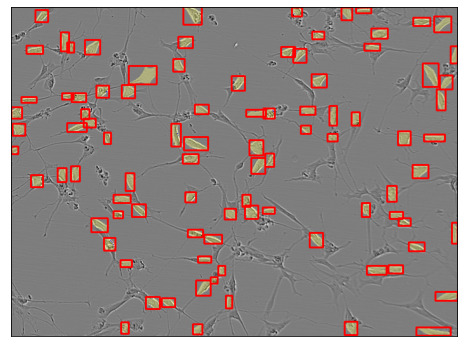

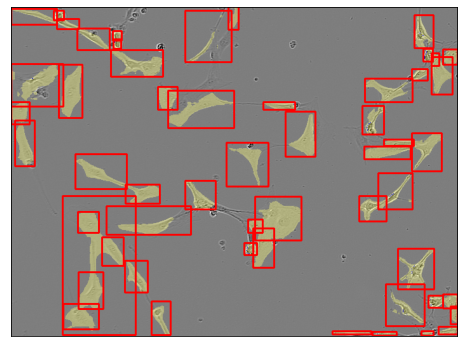

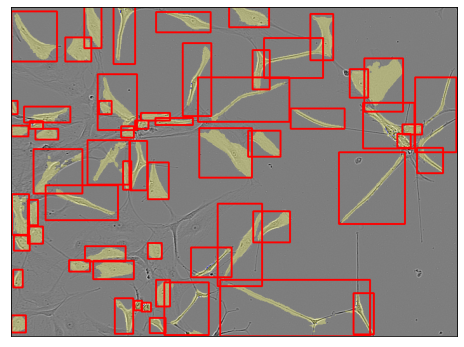

In [6]:
answers = {
    "id": [],
    "predicted" : [],
}
for image_path in test_images_dir.glob("**/*.png"):
    image = io.imread(str(image_path))
    masks = predict_masks(image, model)
    answers["id"].extend(image_path.stem for i in range(len(masks)))
    answers["predicted"].extend(" ".join(map(str, rle_encode(mask.transpose()))) for mask in masks)

In [7]:
submission = pd.DataFrame(answers)
submission.sample(8)

,id,predicted
5,7ae19de7bc2a,237311 2 237830 4 238350 6 238869 8 239389 9 2...
170,d8bfd1dafdc4,35136 1 35655 3 36175 3 36695 4 37210 9 37729 ...
91,7ae19de7bc2a,351131 2 351648 5 352166 7 352684 9 353201 12 ...
195,d8bfd1dafdc4,101591 3 102108 7 102625 10 103143 12 103663 1...
133,d48ec7815252,178585 1 179105 2 179625 2 180145 3 180665 4 1...
14,7ae19de7bc2a,140922 1 141442 2 141962 3 142482 4 143002 5 1...
121,d48ec7815252,330763 9 330777 3 331280 14 331296 5 331797 24...
179,d8bfd1dafdc4,67353 2 67870 6 68389 8 68908 9 69427 10 69944...


In [8]:
submission.to_csv("submission.csv", index=False)